In [1]:
%load_ext autoreload
%autoreload 2

# Moving edge responses

This notebook introduces moving edge responses and the direction selectivity index (DSI). The DSI measures motion selectivity of cells to visual input.

**Select GPU runtime**

To run the notebook on a GPU select Menu -> Runtime -> Change runtime type -> GPU.

In [2]:
# @markdown **Check access to GPU**

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    import torch

    try:
        cuda_name = torch.cuda.get_device_name()
        print(f"Name of the assigned GPU / CUDA device: {cuda_name}")
    except RuntimeError:
        import warnings

        warnings.warn(
            "You have not selected Runtime Type: 'GPU' or Google could not assign you one. Please revisit the settings as described above or proceed on CPU (slow)."
        )

**Install Flyvis**

The notebook requires installing our package `flyvis`. You may need to restart your session after running the code block below with Menu -> Runtime -> Restart session. Then, imports from `flyvis` should succeed without issue.

In [3]:
if IN_COLAB:
    #@markdown **Install Flyvis**
    %%capture
    !git clone https://github.com/flyvis/flyvis-dev.git
    %cd /content/flyvis-dev
    !pip install -e .

In [4]:
# basic imports
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.rcParams['figure.dpi'] = 200

## Moving edge stimuli

To elicit moving edge responses and characterise the motion selectivity of neurons, experimenters show an ON or OFF edge moving in different cardinal directions. We generate and render these stimuli with the `MovingEdge` dataset.

In [11]:
# import dataset and visualization helper
from flyvision.datasets.moving_bar import MovingEdge
from flyvision.animations.hexscatter import HexScatter

In [12]:
# initialize dataset
# make the dataset
dataset = MovingEdge(
    offsets=[-10, 11],  # offset of bar from center in 1 * radians(2.25) led size
    intensities=[0, 1],  # intensity of bar
    speeds=[19],  # speed of bar in 1 * radians(5.8) / s
    height=80,  # height of moving bar in 1 * radians(2.25) led size
    post_pad_mode="continue",  # for post-stimulus period, continue with the last frame of the stimulus
    t_pre=1.0,  # duration of pre-stimulus period
    t_post=1.0,  # duration of post-stimulus period
    dt=1 / 200,  # temporal resolution of rendered video
    angles=list(np.arange(0, 360, 30)),  # motion direction (orthogonal to edge)
)

In [13]:
# view stimulus parameters
dataset.arg_df
# the dataset has four samples, one corresponding to each row

,angle,width,intensity,t_stim,speed
0,0,80,0,0.428766,19
1,0,80,1,0.428766,19
2,30,80,0,0.428766,19
3,30,80,1,0.428766,19
4,60,80,0,0.428766,19
5,60,80,1,0.428766,19
6,90,80,0,0.428766,19
7,90,80,1,0.428766,19
8,120,80,0,0.428766,19
9,120,80,1,0.428766,19


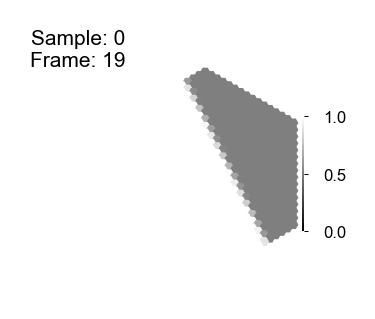

In [8]:
# visualize single sample
# %#matplotlib notebook
animation = HexScatter(
    dataset[3][None, ::25, None], vmin=0, vmax=1
)  # intensity=1, radius=6
animation.animate_in_notebook()

## Moving edge response

Now that we have generated the stimulus, we can use it to drive a trained connectome-constrained network.

In [14]:
from flyvision import results_dir
from flyvision.network import NetworkView

# model are already sorted by task error
# we take the best task-performing model from the pre-sorted ensemble
network_view = NetworkView(results_dir / "flow/0000/000")

[2024-09-13 07:37:50] Initialized network view at /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/000.


In [15]:
# rebuild network from checkpoint
network = network_view.init_network()

[2024-09-13 07:37:59] Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2024-09-13 07:37:59] Recovered network state.


In [17]:
responses = np.concatenate(
    [
        ret[1]
        for ret in network.stimulus_response(
            stim_dataset=dataset,
            dt=dataset.dt,
            t_pre=0.0,
        )
    ],
    axis=0,
)

[2024-09-13 07:41:29] Computing 24 stimulus responses.


Batch:   0%|          | 0/24 [00:00<?, ?it/s]

### MovingEdgeResponseView
We've now computed network moving edge responses for all cells in the network. The `MovingEdgeResponseView` class allows us fast and flexible analysis and operations on the stored responses.

In [36]:
from flyvision.utils.nodes_edges_utils import CellTypeArray
from flyvision.analysis.moving_bar_responses import MovingEdgeResponseView

# extract cell responses in central column
central_responses = responses[:, :, network.connectome.central_cells_index[:]]
# wrap responses for easy access by cell type
responses_array = CellTypeArray(
    central_responses[None], # add model dimension
    cell_types=network.connectome.unique_cell_types[:].astype(str),
)

In [76]:
# initialize MovingEdgeResponseView
merv = MovingEdgeResponseView(
    arg_df=dataset.arg_df, 
    responses=responses_array, 
    config=dataset.config,
    stim_sample_dim=1,
    temporal_dim=2
)

### Response traces
We can plot single-cell response traces with `MovingEdgeResponseView.plot_traces()`. Here, we plot responses of T4c cells to edges with intensity 1 (ON edges).

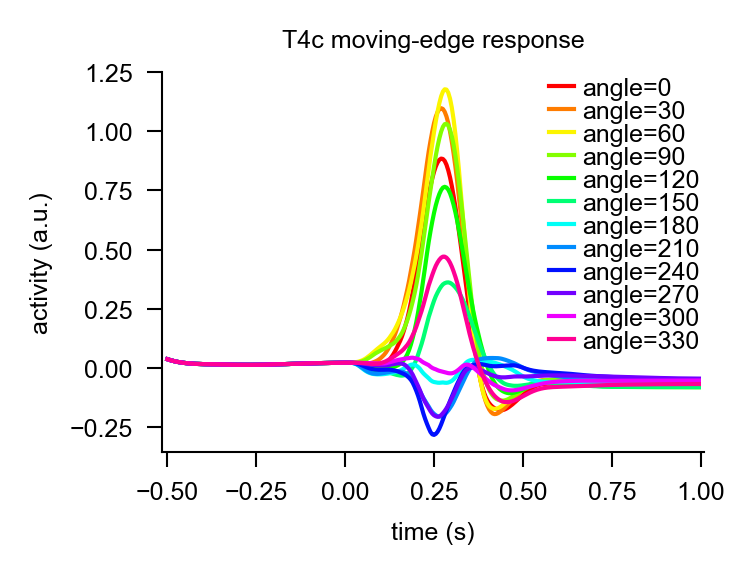

In [49]:
# %#matplotlib inline
merv.plot_traces(
    cell_type="T4c",
    groupby=["angle"],
    intensity=1,
    t_start=-0.5,
    t_end=1.0,
    plot_kwargs=dict(
        figsize=(2.4, 1.8),
        fontsize=6,
        color=[plt.cm.hsv(x) for x in np.arange(0, 1, 1 / 12)],
    ),
)
plt.show()

### Direction selectivity index (DSI)

The **Direction Selectivity Index (DSI)** quantifies a cell's preference for stimuli moving in a particular direction.

The DSI is derived from the following steps:
1. Obtain the neuron's peak responses to stimuli moving in different directions $\theta$ and at different speeds $S$.
2. Rectify these peak responses to ensure they are non-negative.
3. Compute the DSI using the equation:

$$
DSI_{t_i}(I) = \frac{1}{\lvert S \rvert} \sum_{S \in S} \left\lvert \frac{\sum_{\theta \in \Theta} r^{peak}_{t_{central}}(I, S, \theta) e^{i\theta}}{\max_{I \in I} \left\lvert \sum_{\theta \in \Theta} r^{peak}_{t_{central}}(I, S, \theta) \right\rvert} \right\rvert
$$

Where:
- $DSI_{t_i}(I)$ is the Direction Selectivity Index for cell type $t_i$ at stimulus intensity $I$.
- $\lvert S \rvert$ is the number of different speeds at which stimuli are moved.
- $r^{peak}_{t_{central}}(I, S, \theta)$ represents the rectified peak response of the central cell in hexagonal space of a cell type, for a given stimulus intensity $I$, speed $S$, and direction $\theta$.
- $\theta$ is varied across all tested directions $\Theta$.
- $e^{i\theta}$ introduces the directional component by weighting the response by the complex exponential of the angle of movement.
- The denominator normalizes the responses, ensuring that DSI values range from 0 to 1.

The DSI values range from 0 to 1. A DSI of 0 indicates no directional preference, while a DSI of 1 indicates a strong preference for a specific direction.

For the T4c cell plotted before, we can see that it preferentially responds to ON edges moving at an angle of 60 degrees, so we expect to see a large DSI. We can compute the DSI with `MovingEdgeResponseView.dsi()`.

In [51]:
# get DSI for T4c cell
dsi_T4c = merv.where_stim_args(intensity=1).cell_type("T4c").dsi()[:].squeeze()
print(f"T4c DSI: {dsi_T4c}")

T4c DSI: 0.628965766050319


We can also compute the preferred direction of the cell with `MovingEdgeResponseView.preferred_direction()` (this is the direction that the tuning lobe points towards). We would expect the preferred direction to be around 60 degrees based on the response traces.

In [78]:
preferred_direction = (
    merv.where_stim_args(intensity=1)
    .cell_type("T4c")
    .preferred_direction()[:]
    .squeeze()
)
print(f"T4c preferred direction: {preferred_direction / np.pi * 180} degrees")

T4c preferred direction: 56.276179588457495 degrees


We can also inspect the direction selecity of a cell type visually, by plotting the angular tuning with `MovingEdgeResponseView.plot_angular_tuning()`. Here we see clearly how the cell is tuned to stimuli moving at a 60 degree angle.

(<Figure size 300x300 with 1 Axes>, <PolarAxes: >)

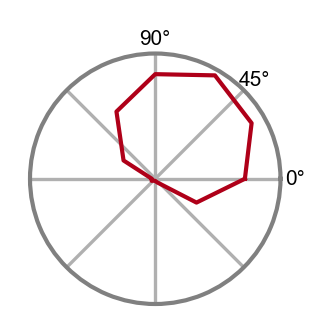

In [79]:
merv.plot_angular_tuning(cell_type="T4c", intensity=1)

### DSI  and tuning curve correlation

With the `dsi()` function we can also compute DSIs for every cell type at once. Since the selectivity of some cell types have been determined experimentally, we can then compare our model to experimental findings by computing the correlation between the model DSIs for known cell types with their expected motion selectivity.

In [80]:
from flyvision.analysis.moving_bar_responses import dsi_correlation_to_known

# compute DSIs for all cell types
dsi_all = merv.dsi()
# get DSI values and corresponding cell type
off_dsis = dsi_all.where_stim_args(intensity=0)
on_dsis = dsi_all.where_stim_args(intensity=1)
dsis = np.stack([off_dsis[:], on_dsis[:]], axis=0)[:, :, 0]  # remove temproal dim
cell_types = dsi_all.responses.cell_types
# compute correlation
dsi_corr = dsi_correlation_to_known(dsis, cell_types, respect_contrast=True).squeeze()
print(f"DSI correlation = {dsi_corr}")

NotImplementedError: 

Further, for certain cell types, their actual tuning curves have also been measured experimentally, so we can correlate our model cell's tuning to the true values. For T4c, the cell is known to tune to stimuli moving at 90 degrees, so the correlation should be relatively high.

In [19]:
from flyvision.analysis.moving_bar_responses import tuning_curve_correlation_to_known

# compute DSIs for all cell types
tuning_curve, (angles, intensities) = merv.tuning_curves()
# get DSI values and corresponding cell type
tc_corr = tuning_curve_correlation_to_known(
    tuning=tuning_curve, angles=angles, intensities=intensities
)
print(f"T4c tuning curve correlation = {tc_corr['T4c']}")

T4c tuning curve correlation = 0.537320702552628


In fact, tuning curves for all T4 and T5 cells have been measured, so we can compute the correlation for all 8 cell types.

In [20]:
import pprint

print(f"Tuning curve correlations: \n{pprint.pformat(tc_corr)}")

Tuning curve correlations: 
{'T4a': array(0.93697634),
 'T4b': array(0.71937983),
 'T4c': array(0.5373207),
 'T4d': array(0.85625696),
 'T5a': array(0.84124553),
 'T5b': array(0.90314504),
 'T5c': array(0.94954757),
 'T5d': array(0.90105058)}


So, the model yields accurate predictions for all T4 and T5 cell types.

## Ensemble responses

Now we can compare motion selectivity properties across an ensemble of trained models. First we need to again simulate the network responses.

In [83]:
from flyvision import EnsembleView

ensemble = EnsembleView(results_dir / "flow/0000")

Loading ensemble:   0%|          | 0/50 [00:00<?, ?it/s]

[2024-09-13 08:14:17] Loaded 50 networks.


In [84]:
central_cells_index = ensemble[0].connectome.central_cells_index[:]
with ensemble.ratio(
    best=0.20
):  # take only top 20% (10 in this case) of models
    responses = np.stack(
        list(
        ensemble.simulate_from_dataset(
            dataset, dt=dataset.dt, 
            batch_size=4, 
            central_cell_only=True, 
        )
    ))

Simulating network:   0%|          | 0/10 [00:00<?, ?it/s]

[2024-09-13 08:14:28] Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2024-09-13 08:14:28] Recovered network state.
[2024-09-13 08:14:28] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-09-13 08:14:32] Recovered network state.
[2024-09-13 08:14:33] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-09-13 08:14:37] Recovered network state.
[2024-09-13 08:14:37] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-09-13 08:14:42] Recovered network state.
[2024-09-13 08:14:42] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-09-13 08:14:46] Recovered network state.
[2024-09-13 08:14:47] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-09-13 08:14:51] Recovered network state.
[2024-09-13 08:14:51] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-09-13 08:14:56] Recovered network state.
[2024-09-13 08:14:56] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-09-13 08:15:00] Recovered network state.
[2024-09-13 08:15:01] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-09-13 08:15:05] Recovered network state.
[2024-09-13 08:15:05] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

[2024-09-13 08:15:10] Recovered network state.
[2024-09-13 08:15:10] Computing 24 stimulus responses.


Batch:   0%|          | 0/6 [00:00<?, ?it/s]

We again use `MovingEdgeResponseView` to wrap around the network responses to moving edges.

In [85]:
responses_array = CellTypeArray(
    responses,
    cell_types=network.connectome.unique_cell_types[:].astype(str),
)

In [86]:
merv = MovingEdgeResponseView(
    arg_df=dataset.arg_df,
    responses=responses_array,
    config=dataset.config,
    stim_sample_dim=1,
    temporal_dim=2,
)

### Response traces

We can once again plot response traces for a single cell type. We subtract the initial value of each trace and rescale by the maximum value before plotting, as the network neuron activities are in arbitrary units. We plot only T4c responses to ON edges moving at a 90-degree angle.

/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/flyvision/utils/activity_utils.py:498: RuntimeWarning: invalid value encountered in true_divide
  return self.view(responses=self[:] / other[:])


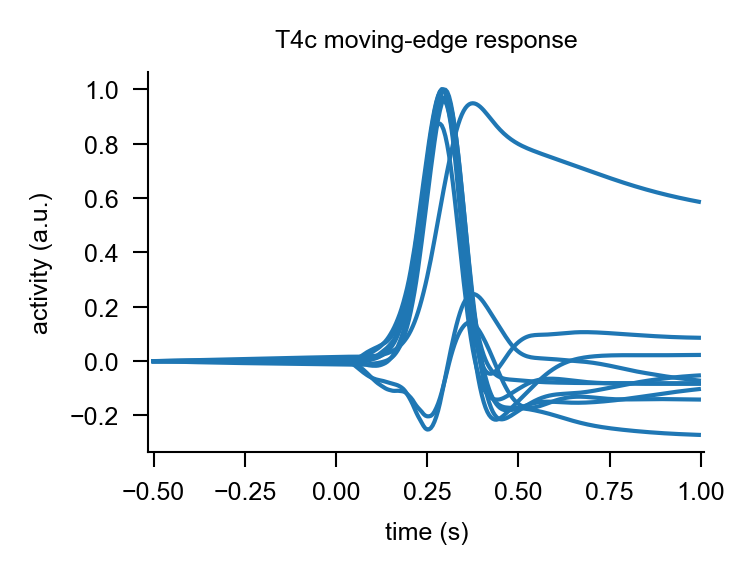

In [87]:
centered = (
    merv.between_seconds(-0.5, 1.0)
    - merv.between_seconds(-0.5, 1.0).responses.array[:, :, [0]]
)
centered /= centered.abs().max(dims=(1, 2), keepdims=True)
centered.plot_traces(
    cell_type="T4c",
    angle=90,
    intensity=1,
    plot_kwargs=dict(figsize=(2.4, 1.8), fontsize=6),
)
plt.show()

Though for most networks T4c responses are correctly predicted to the stimuli, there are some networks in the ensemble with different tuning.

### Direction selectivity index (DSI)

We can also compute direction selectivity indices for each network in the ensemble.

In [102]:
# get DSI for T4c cell
dsi_l1 = merv.where_stim_args(intensity=1).cell_type("T4c").dsi()[:].squeeze().tolist()
dsi_l1

[0.6273619097364439,
 0.6078009078176843,
 0.6865688668992623,
 0.39075935856882055,
 0.5202174452616458,
 0.3854073505803591,
 0.7031159751130313,
 0.5475362568822092,
 0.021946043932143812,
 0.7027019168267326]

Most networks in this group recover some direction selectivity for T4c. We can also plot the distribution of DSIs per cell type for both ON and OFF-edge stimuli across the ensemble.

In [103]:
# compute FRIs for all cell types
dsi_all = merv.dsi()
# get FRI values and corresponding cell types
dsis = dsi_all.responses.array.squeeze()
cell_types = dsi_all.responses.cell_types

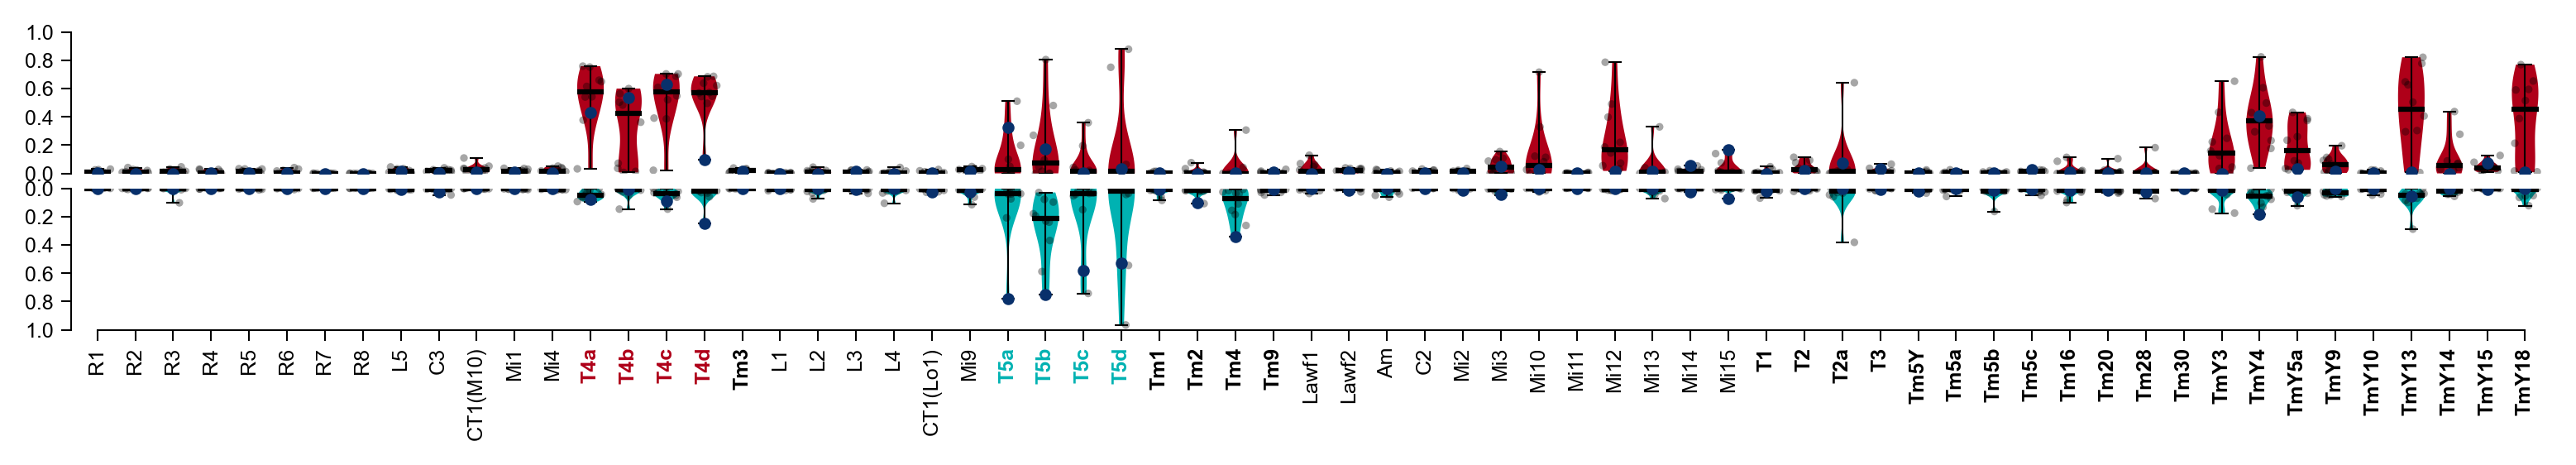

In [104]:
from flyvision.analysis.moving_bar_responses import plot_dsis

fig, ax = plot_dsis(
    dsis,
    cell_types,
    bold_output_type_labels=True,
    output_cell_types=ensemble[ensemble.names[0]]
    .connectome.output_cell_types[:]
    .astype(str),
    figsize=[10, 1.2],
    color_known_types=True,
    fontsize=6,
    scatter_best_index=0,
    scatter_best_color=plt.get_cmap("Blues")(1.0),
)
fig.show()

### DSI correlation

Lastly, we look at the correlations to ground-truth DSIs and tuning curves across the ensemble. This provides us with a high-level understanding of the accuracy of known motion tuning predictions. 

In [105]:
off_dsis = dsi_all.where_stim_args(intensity=0)
on_dsis = dsi_all.where_stim_args(intensity=1)
dsis = np.stack([off_dsis[:], on_dsis[:]], axis=0)[:, :, 0]  # remove temproal dim
cell_types = dsi_all.responses.cell_types
dsi_corr = dsi_correlation_to_known(dsis, cell_types, respect_contrast=True)

tuning_curve, (angles, intensities) = merv.tuning_curves()
tc_corr = tuning_curve_correlation_to_known(
    tuning_curve, angles, intensities, aggregate_dims=3
)

t4_corr = np.median(
    [tc_corr[cell_type].squeeze() for cell_type in ["T4a", "T4b", "T4c", "T4d"]], axis=0
)
t5_corr = np.median(
    [tc_corr[cell_type].squeeze() for cell_type in ["T5a", "T5b", "T5c", "T5d"]], axis=0
)

NotImplementedError: 

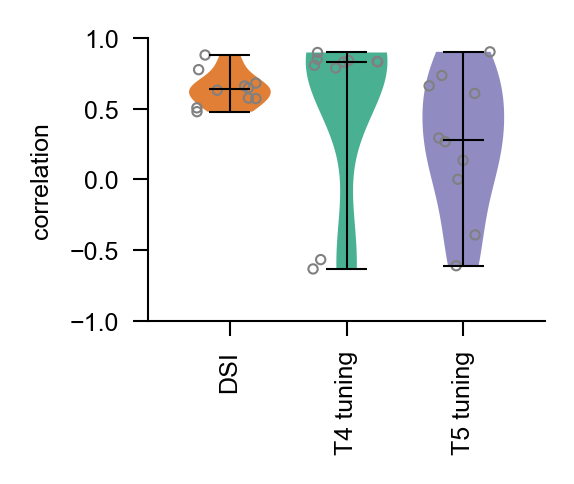

In [30]:
from flyvision.plots.plots import violin_groups

fig, ax, *_ = violin_groups(
    np.stack([dsi_corr, t4_corr, t5_corr], axis=0)[:, None, :],
    ["DSI", "T4 tuning", "T5 tuning"],
    ylabel="correlation",
    figsize=(1.8, 1.5),
    ylim=(-1, 1),
    colors=[
        plt.get_cmap("Dark2")(0.125),
        plt.get_cmap("Dark2")(0),
        plt.get_cmap("Dark2")(0.25),
    ],
    color_by="experiments",
    scatter_edge_color="gray",
    scatter_radius=5,
    violin_alpha=0.8,
)

<!-- ... Models in general have very good match to known single-neuron tuning properties, with median correlation around $0.8$. -->